In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from dataset import create_dataloader

In [2]:
"""
class VAE(nn.Module):
    def __init__(self, input_dim=128, last_hidden_dim=128):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        #wenn zeit ist mit cnns statt linear
        self.encoder = nn.Sequential(
            nn.Linear(input_dim**2, last_hidden_dim*10), #anzahl der layers und dimension variabel machen
            nn.LeakyReLU(0.2),
            nn.Linear(input_dim*10, last_hidden_dim*5),
            nn.LeakyReLU(0.2),
            nn.Linear(input_dim*5, last_hidden_dim*2),
            nn.LeakyReLU(0.2),
            nn.Linear(last_hidden_dim*2, last_hidden_dim),
            nn.LeakyReLU(0.2)
            )  
        # man kann nicht den mean und varianz berechnen sonst stimmen die dimensionen nicht evtll später mit mean und var in einem vektor probieren
        self.mean = nn.Linear(last_hidden_dim, last_hidden_dim)
        self.var = nn.Linear(last_hidden_dim, last_hidden_dim)
        
        self.decoder = nn.Sequential(
            nn.Linear(last_hidden_dim, last_hidden_dim*2),
            nn.LeakyReLU(0.2),
            nn.Linear(last_hidden_dim*2, last_hidden_dim*5),
            nn.LeakyReLU(0.2),
            nn.Linear(last_hidden_dim*5, last_hidden_dim*10),
            nn.LeakyReLU(0.2),
            nn.Linear(last_hidden_dim*10, input_dim**2),
            )    
        
    def encode(self, x): 
        x = x.view(x.size(0), -1)     
        x = self.encoder(x)
        var = self.var(x)
        var = torch.clamp(var, min=1e-6) #sont kann KL nan ausgeben wegen negativem log
        mean = self.mean(x)
        return var, mean
        
    def reparameterization(self, mean, var):
        self.norm = torch.distributions.Normal(0, 1)
        epsilon = self.norm.sample(var.shape)   
        z = mean + var * epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        var, mean = self.encode(x)
        z = self.reparameterization(mean, var)
        x_hat = self.decode(z)
        x_hat = x_hat.reshape((-1, 1, self.input_dim, self.input_dim))
        return x_hat, mean, var
"""
class VAE(nn.Module):
    def __init__(self, input_dim=128, last_hidden_dim=128):
        super(VAE, self).__init__()
        self.input_dim = input_dim

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  
            nn.LeakyReLU(0.2),
            nn.Flatten(),
        )

        self.flattened_dim = (input_dim // 8) * (input_dim // 8) * 128

        self.mean = nn.Linear(self.flattened_dim, last_hidden_dim)
        self.var = nn.Linear(self.flattened_dim, last_hidden_dim)

        self.decoder_input = nn.Linear(last_hidden_dim, self.flattened_dim)

        self.decoder = nn.Sequential(
            nn.Unflatten(1, (128, input_dim // 8, input_dim // 8)),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),  
        )

    def encode(self, x):
        x = self.encoder(x)
        var = torch.clamp(self.var(x), min=1e-6)
        mean = self.mean(x)
        return var, mean

    def reparameterization(self, mean, var):
        self.norm = torch.distributions.Normal(0, 1)
        epsilon = self.norm.sample(var.shape) 
        z = mean + var * epsilon
        return z

    def decode(self, z):
        x = self.decoder_input(z)
        x = self.decoder(x)
        return x

    def forward(self, x):
        var, mean = self.encode(x)
        z = self.reparameterization(mean, var)
        x_hat = self.decode(z)
        return x_hat, mean, var

In [3]:
def loss_function(x, x_hat, mean, var, model):
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(2*torch.log(var) - mean*mean - var*var + 1)
    l2_reg = sum(torch.sum(param**2) for param in model.parameters())
    return reproduction_loss + KLD + l2_reg*1e-6 

In [ ]:
brains = ['B01', 'B02', 'B05']  # Training brains
brains = ["B20"]
hdf5_file_path = 'data/cell_data.h5'
tile_size = 128
batch_size = 32
tiles_per_epoch = 100
dataloader = create_dataloader(hdf5_file_path, brains, tile_size, batch_size, tiles_per_epoch, num_workers=0)

model = VAE(input_dim=tile_size, last_hidden_dim=128)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 30

In [5]:
def train(model, dataloader, optimizer, loss_function, epochs, batch_size):
    epoch_losses = []
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for i, x in enumerate(dataloader):
            optimizer.zero_grad()
            x_hat, mean, var = model(x)
            loss = loss_function(x, x_hat, mean, var, model)
            overall_loss += loss.item()
            loss.backward()
            optimizer.step()
        average_loss = overall_loss / len(dataloader)
        epoch_losses.append(average_loss)
        print(f"Epoch {epoch + 1}/{epochs}, Average Loss: {average_loss:.4f}")
    
    return epoch_losses
    
train(model, dataloader, optimizer, loss_function, epochs, batch_size)

Epoch 1/10, Average Loss: 97613.0870
Epoch 2/10, Average Loss: 112891.4417
Epoch 3/10, Average Loss: 76571.5519
Epoch 4/10, Average Loss: 88969.2233
Epoch 5/10, Average Loss: 76602.7900
Epoch 6/10, Average Loss: 75188.8887
Epoch 7/10, Average Loss: 63237.0122
Epoch 8/10, Average Loss: 71339.9730
Epoch 9/10, Average Loss: 58348.1434
Epoch 10/10, Average Loss: 64927.7809


[97613.08703125,
 112891.44171875,
 76571.551875,
 88969.22328125,
 76602.79,
 75188.88875,
 63237.0121875,
 71339.97296875,
 58348.1434375,
 64927.7809375]

Original batch shape: torch.Size([4, 1, 128, 128])


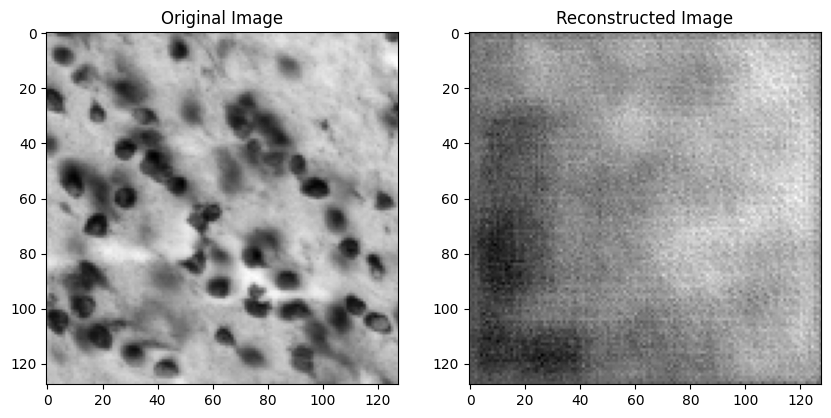

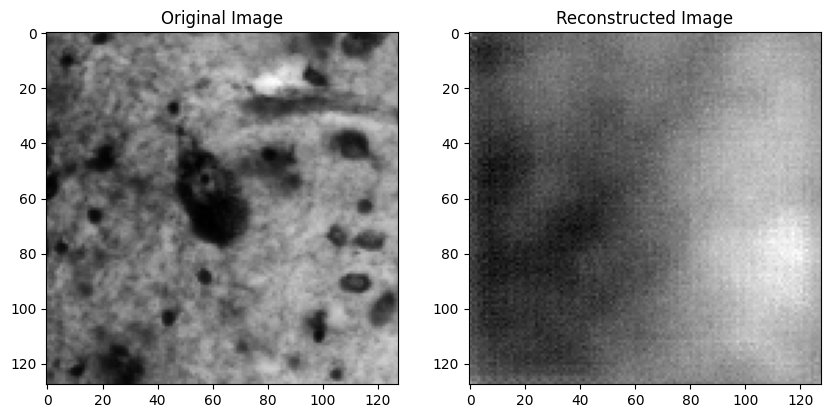

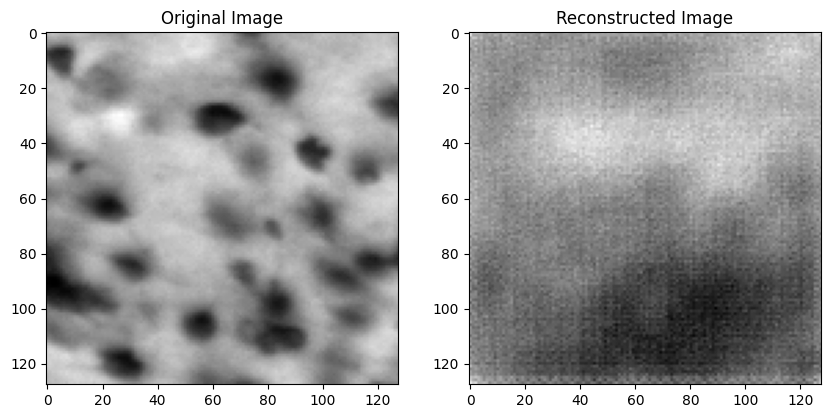

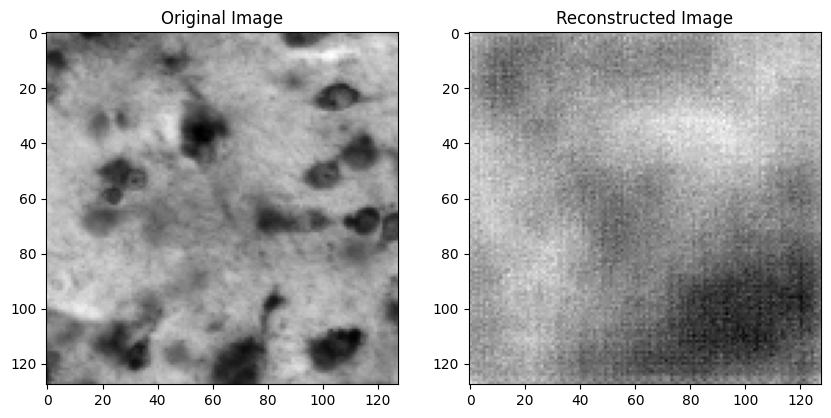

In [6]:
import matplotlib.pyplot as plt
import torch

for batch in dataloader:
    images = batch  
    print(f"Original batch shape: {images.shape}")
    x_hat, mean, var = model(images)
    reconstructed_images = x_hat.view(batch_size, 128, 128)

    for i in range(batch_size):
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(images[i].squeeze().numpy(), cmap='gray')
        ax[0].set_title("Original Image")
        ax[1].imshow(reconstructed_images[i].detach().numpy(), cmap='gray')
        ax[1].set_title("Reconstructed Image")
        plt.show()
    
    break  
